# Исследование данных сервиса аренды самокатов GoFast

В нашем распоряжении данные компании «GoFast» — сервиса аренды самокатов. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться: без подписки и с подпиской «Ultra». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстоит сделать предварительный анализ на небольшой выборке клиентов. В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках.

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import display_html

## Загрузка данных

Прочитаем данные и сохраним в data.

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Просмотрим общую информацию о данных.

In [3]:
# просмотр общей информации о пользователях
data_users.info()
data_users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Согласно документации к данным, в таблице `users_go` содержится информация о пользователях и имеются следующие столбцы:
* `user_id` — уникальный идентификатор пользователя
* `name` — имя пользователя
* `age` — возраст пользователя
* `city` — город
* `subscription_type` — тип подписки (free, ultra)

In [4]:
# просмотр общей информации о поездках
data_rides.info()
data_rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Согласно документации к данным, в таблице `rides_go` содержится информация о поездках и имеются следующие столбцы:
* `user_id` — уникальный идентификатор пользователя
* `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` — дата совершения поездки	

In [5]:
# просмотр общей информации о подписках
data_subscriptions.info()
data_subscriptions.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Согласно документации к данным, в таблице `rides_go` содержится информация о подписках и имеются следующие столбцы:
* `subscription_type` — тип подписки
* `minute_price` — стоимость одной минуты поездки по данной подписке
* `start_ride_price` — стоимость начала поездки
* `subscription_fee` — стоимость ежемесячного платежа	

Простмотрев общую информацию о данных, можно уже заметить некотрые неудобства в типах даннных (в таблице *data_rides* даты имеют тип *object*). На первый взгляд каких либо осбенно ярких проблем не выделяется.

## Предобработка данных

Подготовим данные для дальнейшей работы. Исправим типы и проверим наличие/отсутвие пропущенных значений.

Переведем даты в datetime.

In [6]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверка пропущенных значений в data_users.

In [7]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Проверка пропущенных значений в data_rides.

In [8]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

Проверка пропущенных значений в data_rides.

In [9]:
data_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверка показывает, что ни в одном датафрейме пропущенных значений нет.

Проверим наличие явных дубликатов.

In [10]:
print("Количество дубликатов в data_users", data_users.duplicated().sum())
print("Количество дубликатов в data_rides", data_rides.duplicated().sum())
print("Количество дубликатов в data_subscriptions", data_subscriptions.duplicated().sum())

Количество дубликатов в data_users 31
Количество дубликатов в data_rides 0
Количество дубликатов в data_subscriptions 0


В таблице с пользователями присутсвую строки дубликаты, поэтому удалим их.

In [11]:
data_users = data_users.drop_duplicates()
data_users.duplicated().sum()

0

В таблице `data_users` есть строковые столбцы *name*(имя пользователя) и *city*(название города). Проверим их на наличие неявных дубликатов. Выведем список уникальных значений *name*.

In [12]:
data_users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

Неявных дубликатов в именах нет.

Выведем список уникальных значений *city*.

In [13]:
data_users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Неявных дубликатов в названиях городов нет.

Для дальнейшего анализа создадим в `data_rides` столбец с номером месяца.

In [14]:
data_rides['month'] = data_rides['date'].dt.month
data_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Вывод этапа**:
- Проведена проверка данных на начличие пропущенных значений. Нигде пропусков не обнаружено.
- Были обработаны неявные и явные дубликаты. Явные дубликаты из `data_users`в количестве 31 строки удалены из таблицы.
- Столбец с датой приведен к формату *datetime* и добавлен новый столбец с номером месяца (*month*)

## Исследовательский анализ данных

**Посмотрим на частоту встречаемости городов.**

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

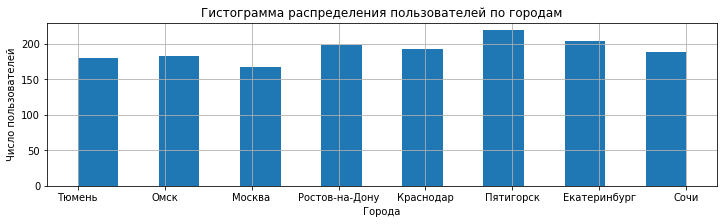

In [15]:
data_users['city'].hist(figsize = (12, 3), bins = 15)
plt.title('Гистограмма распределения пользователей по городам')
plt.xlabel('Города')
plt.ylabel('Число пользователей')
data_users['city'].value_counts()

По гистограмме и таблице видно: самым крупным городом количеству пользователей является Пятигорск со значением 219, а самым маленьким - Москва с 168 пользователями.

**Посмотрим соотношение пользователей с подпиской и без.**

free     835
ultra    699
Name: subscription_type, dtype: int64

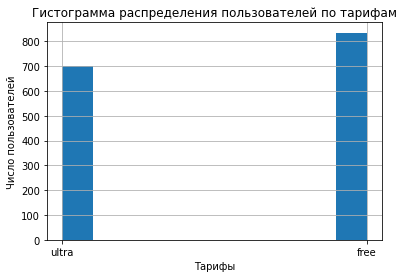

In [16]:
data_users['subscription_type'].hist()
plt.title('Гистограмма распределения пользователей по тарифам')
plt.xlabel('Тарифы')
plt.ylabel('Число пользователей')
data_users['subscription_type'].value_counts()

Пользователей без подписки всё-таки больше, хотя разница не сильно велика и составляет всего 136 пользователей.

**Посмотрим возраст пользователей.**

Для начала проверим какой в целом разброс возраста в имеющихся данных.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

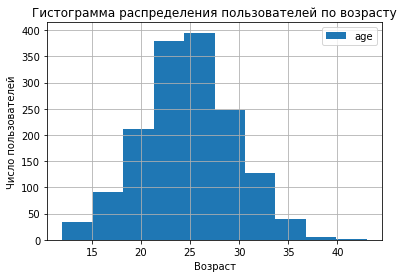

In [17]:
data_users.plot(y = 'age', kind = 'hist', grid=True)
plt.title('Гистограмма распределения пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')
data_users['age'].describe()

Гистограмма имеет нормальное распределение. 
Основной диапазон пользователей это люди от 22 до 28 лет. Очень редки пользователи 40+, что в целом не удивительно, люди старшего возраста редко предпоситают использовать самокаты.

**Исследуем расстояния проезжаемые за одну поездку.**

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

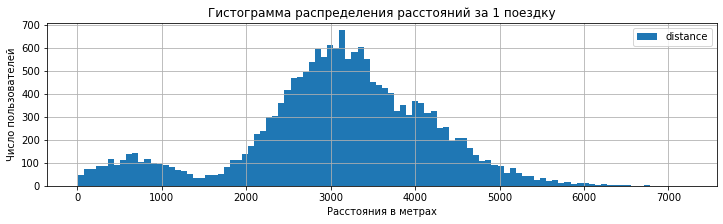

In [18]:
data_rides.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
plt.title('Гистограмма распределения расстояний за 1 поездку')
plt.xlabel('Расстояния в метрах')
plt.ylabel('Число пользователей')
data_rides['distance'].describe()

Наблюдаем 2 волны на графике. Это можно объяснить тем, что многие пользователи не всегда планируют длительное времяпрепровождения на самокате и хотят покататься лишь пару минут (сюда можно добавить также пользователей, котрые быстро устали или впервые попрбовали покататься). Втрорую волну вероятно можно отнести к пользоватлям, предпочитающим длительные поездки.

Разделим пользователей на эти две предполагаемые категории и изучим данные.

count    1796.000000
mean      703.889720
std       368.353542
min         0.855683
25%       414.315810
50%       687.536713
75%       985.430276
max      1499.565830
Name: distance, dtype: float64

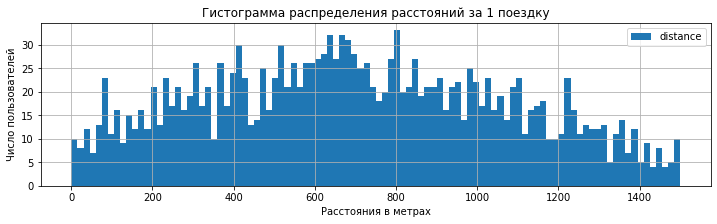

In [19]:
# короткие поездки
short = data_rides[data_rides['distance'] < 1500]
short.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
plt.title('Гистограмма распределения расстояний за 1 поездку')
plt.xlabel('Расстояния в метрах')
plt.ylabel('Число пользователей')
short['distance'].describe()

Короткие поездки распределены нормально, хотя по графику видно, что есть довольно много как резких всплесков, так и падений. В среднем одна такая поездка составляет 704 метра, основной диапазон это поездки от 414 до 985 метров.

count    16272.000000
mean      3331.889043
std        826.722577
min       1502.431070
25%       2742.576736
50%       3239.972305
75%       3874.561063
max       7211.007745
Name: distance, dtype: float64

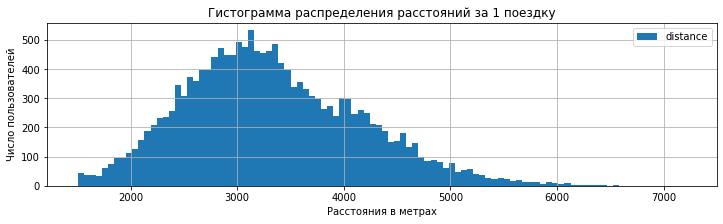

In [20]:
# длинные поездки
long = data_rides[data_rides['distance'] >= 1500]
long.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
plt.title('Гистограмма распределения расстояний за 1 поездку')
plt.xlabel('Расстояния в метрах')
plt.ylabel('Число пользователей')
long['distance'].describe()

Длинные поездки имею распредение Пуассона. Имеются всплески значений, особенно яркий на 4000 метрах.
В среднем одна поездка составляет 3332 метра, а основной диапазон это поездки от 2743 до 3875 метров.
Очень редкими можно назвать поездки свыше 6 км, они практически не встречаются в данных.

**Исследуем продолжительность поездок.**

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

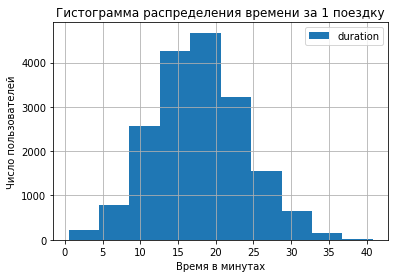

In [21]:
data_rides.plot(y = 'duration', kind = 'hist', grid=True)
plt.title('Гистограмма распределения времени за 1 поездку')
plt.xlabel('Время в минутах')
plt.ylabel('Число пользователей')
data_rides['duration'].describe()

В целом время поездок распределено нормально с некоторым смещением. Основной диапазон это поездки от 14 до 22 минут. В среднем одна поездка составляет 18 минут.

**Вывод этапа**:
Были исследованы характеристики поездок: частота встречаемости городов, соотношение пользователей с подпиской и без, возраст пользователей, расстояние и время за 1 поездку.

Было обнаружено, что расстояния имеют бимодальное распределение, поэтому для более детального анализа поездки распределены на длительные и короткие.

В общем можно сказать, что средняя поездка на самокате предствляет из себя: 
- поездку 14-22 минуты
- при коротком заезде от 414 до 985 метров
- при длительном от 2743 до 3875 метров
- человек возрастом от 22 до 28 лет

Количество пользователей с подпиской и без практически одинаково, а разброс пользователей по городам тоже практически равен, хотя Пятигорск со значением 219 обгоняет Москву с 168 по количеству пользователей.

## Объединение данных

**Создадим общий датафрейм.**

In [22]:
data = data_users.merge(data_rides, how='left', on='user_id')
data = data.merge(data_subscriptions, how='left', on='subscription_type')
print("Количество строк в объединеном датафрейме:", data.shape[0])
data.head(20)

Количество строк в объединеном датафрейме: 18068


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Все строки вошли в новый датафрейм - с ним можно спокойно работать дальше.

Создадим датафреймы с людьми с подписками и без подписок.

In [23]:
# с подпиской
data_ultra = data[data['subscription_type'] == 'ultra'].copy()
# удалим столбец с типом подписки из-за ненадобнасти
data_ultra.drop( columns = data_ultra.columns[4], axis= 1 , inplace= True )
data_ultra.head(10)

,user_id,name,age,city,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,748.690645,15.041884,2021-11-22,11,6,0,199


In [24]:
# без подписки
data_free = data[data['subscription_type'] == 'free'].copy()
# удалим столбец с типом подписки из-за ненадобнасти
data_free.drop( columns = data_free.columns[4], axis= 1 , inplace= True)
data_free.head(10)

,user_id,name,age,city,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,2567.543847,11.312160,2021-06-23,6,8,50,0


**Исследуем время и расстояния для каждого типа подписок**

**Без подписки**

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

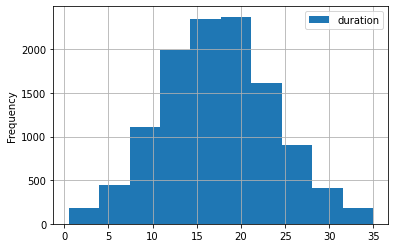

In [25]:
# время поездки
data_free.plot(y = 'duration', kind = 'hist', grid=True)
data_free['duration'].describe()

Время распределено нормально. В среднем одна поездка составляет 17 минут, общий диапазон поездки от 13 до 22 минут. Значения такие же как и у совместных данных.

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

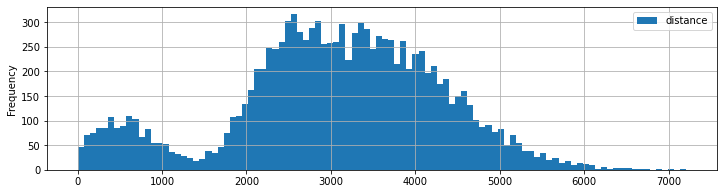

In [26]:
# расстояние
data_free.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
data_free['distance'].describe()

Распределение поездок как и в случае с общими данными является бимодальным, поэтому рассмотри отдельно обе волны.

count    1328.000000
mean      615.268565
std       356.778232
min         0.855683
25%       331.562716
50%       587.754139
75%       854.607332
max      1499.565830
Name: distance, dtype: float64

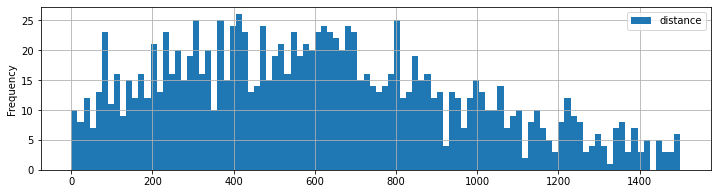

In [27]:
# короткие поездки
short_free = data_free[data_free['distance'] < 1500]
short_free.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
short_free['distance'].describe()

По графику видно, что есть довольно много как резких всплесков, так и падений. В среднем одна такая поездка составляет 615 метра, основной диапазон это поездки от 332 до 855 метров.

count    10240.000000
mean      3360.665309
std        934.086961
min       1502.431070
25%       2612.511671
50%       3293.417470
75%       4012.566738
max       7211.007745
Name: distance, dtype: float64

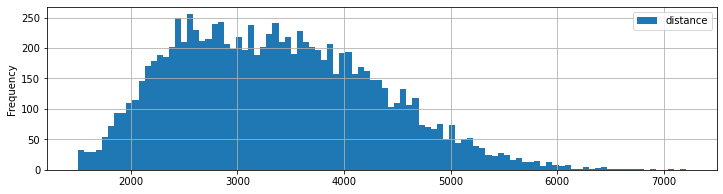

In [28]:
# длинные поездки
long_free = data_free[data_free['distance'] >= 1500]
long_free.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
long_free['distance'].describe()

Длинные поездки имею распредение Пуассона. Имеются всплески значений.
В среднем одна поездка составляет 3360 метров, а основной диапазон это поездки от 2613 до 4013 метров.
Очень редкими можно назвать поездки свыше 6,5 км, они практически не встречаются в данных.

**С подпиской**

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

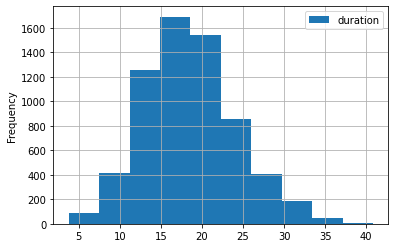

In [29]:
# время поездки
data_ultra.plot(y = 'duration', kind = 'hist', grid=True)
data_ultra['duration'].describe()

Время распределено нормально с небольшим смещением. В среднем одна поездка составляет 19 минут, общий диапазон поездки от 15 до 22 минут.

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

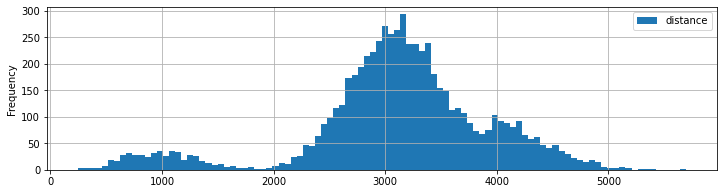

In [30]:
# расстояние
data_ultra.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
data_ultra['distance'].describe()

Распределение поездок как и в случае с общими данными является бимодальным, хотя видно, что второй пик значительно превышает певый, поэтому рассмотри отдельно обе волны.

count     468.000000
mean      955.361714
std       272.247450
min       244.210438
25%       738.709111
50%       959.995200
75%      1160.850269
max      1496.907516
Name: distance, dtype: float64

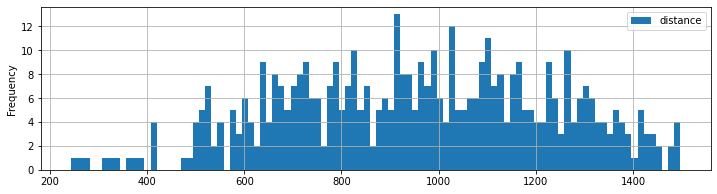

In [31]:
# короткие поездки
short_ultra = data_ultra[data_ultra['distance'] < 1500]
short_ultra.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
short_ultra['distance'].describe()

По графику видно, что есть довольно много как резких всплесков, так и падений. Выделяются всплески в районе 200-400 метров. В среднем одна такая поездка составляет 955 метров, основной диапазон это поездки от 739 до 1161 метров.

count    6032.000000
mean     3283.038087
std       599.031053
min      1507.089621
25%      2873.655690
50%      3191.201785
75%      3616.466838
max      5699.769662
Name: distance, dtype: float64

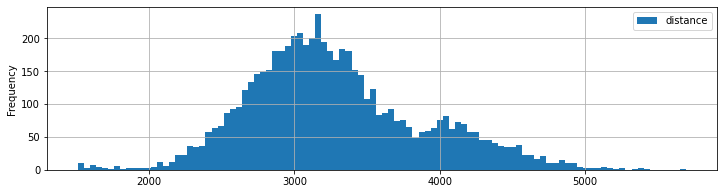

In [32]:
# длинные поездки
long_ultra = data_ultra[data_ultra['distance'] >= 1500]
long_ultra.plot(y = 'distance',bins = 100 , kind = 'hist', grid=True, figsize = (12, 3))
long_ultra['distance'].describe()

Длинные поездки имею распредение Пуассона. Имеются всплески значений в районе 4 км. В среднем одна поездка составляет 3283 метров, а основной диапазон это поездки от 2874 до 3616 метров. Очень редкими можно назвать поездки свыше 5 км, они практически не встречаются в данных.

**Вывод этапа**:
Был создан датафрейм с общими данными `data`, и два датафрейма с данными по пользователям с подпиской `data_ultra` и без `data_free`.

Проведенный анализ расстояний и времени поездок по пользователям с подпиской и без показал:
- Время поездок у разных пользователей практически никак не отличается: без подписки 13-22 минуты, с подпиской 15-22 (лишь немного больше).
- В среднем короткие поездки у бользователей с подпиской длиннее (от 739 до 1161 метров), когда как у людей без подписки от 332 до 855 метров.
- Длинные поездки имеют незначительные отличия в среднем: без подписки от 2613 до 4013, с подпиской от 2874 до 3616 метров (лишь немного больше).
- Замечено, что пользователи без подписки могут проезжать намного большие расстояния, чем пользователи с ней. Без подписки редко встречаются значения более 6 километров, тогда как у людей с подпиской таких значений вообще нет.

## Подсчёт выручки

Создадим новый датафрейм для выручки.

In [33]:
data_income = data.pivot_table(index = ['user_id','name','subscription_type','month'],
                               values = ['distance','duration'], aggfunc = ['sum','count'])
data_income = data_income.drop(columns = ('count', 'duration'))
data_income.columns = ('distance_sum','duration_sum','trips')
data_income = data_income.reset_index()
data_income.head(10)

,user_id,name,subscription_type,month,distance_sum,duration_sum,trips
0,1,Кира,ultra,1,7027.511294,41.416640,2
1,1,Кира,ultra,4,754.159807,6.232113,1
2,1,Кира,ultra,8,6723.470560,44.776802,2
3,1,Кира,ultra,10,5809.911100,31.578017,2
4,1,Кира,ultra,11,7003.499363,53.397424,3
5,1,Кира,ultra,12,6751.629942,27.203912,2
6,2,Станислав,ultra,3,10187.723006,60.959959,3
7,2,Станислав,ultra,4,6164.381824,39.048633,2
8,2,Станислав,ultra,6,3255.338202,13.851127,1
9,2,Станислав,ultra,7,6780.722964,46.170157,2


Добавим столбец с помесячной выручкой.

In [34]:
data_income['month_income'] = np.where(data_income['subscription_type']=='ultra', data_income['trips'] + 6*data_income['duration_sum'] + 199, 50*data_income['trips'] + 8*data_income['duration_sum'])
data_income.head(20)

,user_id,name,subscription_type,month,distance_sum,duration_sum,trips,month_income
0,1,Кира,ultra,1,7027.511294,41.416640,2,449.499843
1,1,Кира,ultra,4,754.159807,6.232113,1,237.392681
2,1,Кира,ultra,8,6723.470560,44.776802,2,469.660815
3,1,Кира,ultra,10,5809.911100,31.578017,2,390.468102
4,1,Кира,ultra,11,7003.499363,53.397424,3,522.384541
5,1,Кира,ultra,12,6751.629942,27.203912,2,364.223471
6,2,Станислав,ultra,3,10187.723006,60.959959,3,567.759752
7,2,Станислав,ultra,4,6164.381824,39.048633,2,435.291800
8,2,Станислав,ultra,6,3255.338202,13.851127,1,283.106764
9,2,Станислав,ultra,7,6780.722964,46.170157,2,478.020944


**Вывод этапа**:
Был создан датафрейм с объединеными данными по пользователям `data_income`, и создан столбец *month_income* содержащий значение выручки кокретного пользователя в конкретный месяц.

## Проверка гипотез

### Гипотеза 1

Проверим гипотезу "Пользователи с подпиской катаются дольше пользователей без подписки". 

**Н0**: "Пользователи с подпиской катаются столько же, сколько и пользователеи без подписки". <br>
**H1**: "Пользователи с подпиской катаются больше пользователей без подписки"

Значение критического уровня вероятности (альфа) примем равным 5%.

In [35]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


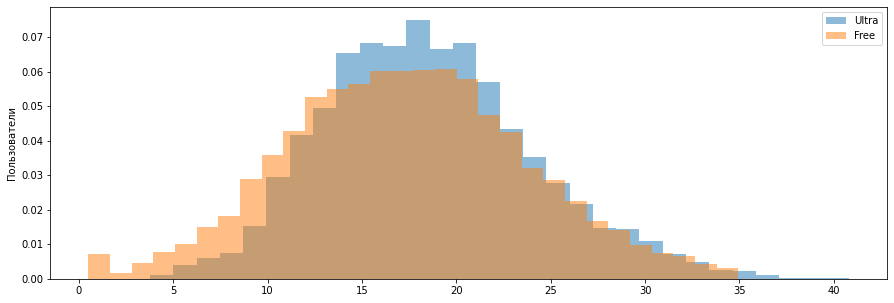

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(data_ultra['duration'], 30, alpha=0.5, density=True, label='Ultra')
ax.hist(data_free['duration'], 30, alpha=0.5, density=True, label='Free')
plt.ylabel('Пользователи')
plt.legend(loc='upper right')
plt.show()

И по результатам теста и по графику видно, что присутсует "превосходство" пользователей с подпиской.
Гипотеза подтверждена.

### Гипотеза 2


Проверим гипотезу "Пользователи с подпиской проезжают не более 3130 метров". 

**Н0**: "Пользователи с подпиской проезжают 3130 метров". <br>
**H1**: "Пользователи с подпиской проезжают менее 3130 метров"

Значение критического уровня вероятности (альфа) примем равным 5%.

In [37]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_1samp(data_ultra['distance'], 3130, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


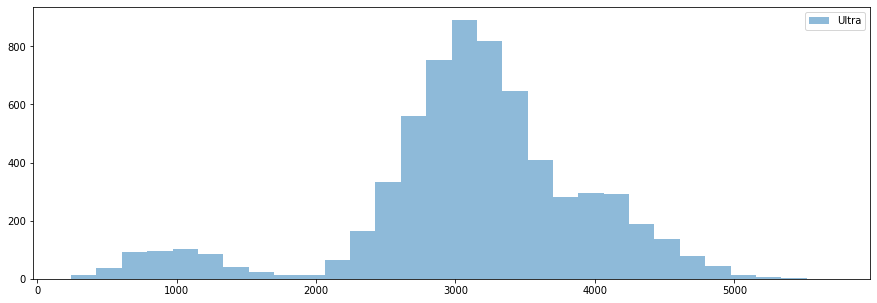

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(data_ultra['distance'], 30, alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.show()

По результатам гипотеза не подтвердилась

### Гипотеза 3


Проверим гипотезу "Помесячная выручка у пользователей с подпиской по месяцам выше". 

**Н0**: "Помесячная выручка у пользователей с подпиской по месяцам равна помесячной выручки у пользователей без подписки". <br>
**H1**: "Помесячная выручка у пользователей с подпиской по месяцам выше помесячной выручки у пользователей без подписки"

Значение критического уровня вероятности (альфа) примем равным 5%.

In [39]:
alpha = 0.05  # критический уровень статистической значимости

#проверим равенство выручки
results = st.ttest_ind(data_income.query('subscription_type == "ultra"')['month_income'], 
                       data_income.query('subscription_type == "free"')['month_income'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 5.592921107806826e-40
Отвергаем нулевую гипотезу


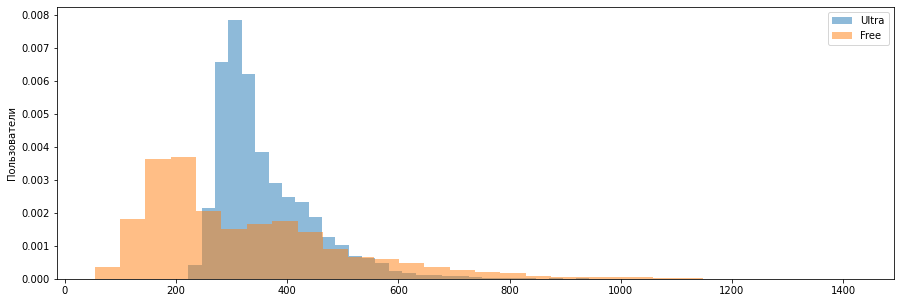

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(data_income.query('subscription_type == "ultra"')['month_income'], 30, alpha=0.5, density=True, label='Ultra')
ax.hist(data_income.query('subscription_type == "free"')['month_income'], 30, alpha=0.5, density=True, label='Free')
plt.ylabel('Пользователи')
plt.legend(loc='upper right')
plt.show()

По результатам тестов гипотеза подтверждена

## Общий вывод

Итак, полученный архив данных -данные о некоторых пользователях из нескольких городов, а также об их поездках сервиса аренды самокатов GoFast.

На этапе предобработки данных была проведена проверка данных на начличие пропущенных значений, которых не оказалось ни в одном столбце данных.Обработаны неявные и явные дубликаты. Явные дубликаты из `data_users`в количестве 31 строки удалены из таблицы.Была исправлена ошибка с неверным форматом данных: столбец с датой приведен к формату *datetime* и добавлен новый столбец с номером месяца (*month*).

На этапе анализа были исследованы характеристики поездок: частота встречаемости городов, соотношение пользователей с подпиской и без, возраст пользователей, расстояние и время за 1 поездку. Обнаружено, что расстояния имеют бимодальное распределение, поэтому для более детального анализа поездки были распределены на длительные и короткие. Выявлено, что средняя поездка на самокате это: поездка 14-22 минуты, при коротком заезде от 414 до 985 метров, при длительном от 2743 до 3875 метров, у пользователя возрастом от 22 до 28 лет.
Количество пользователей с подпиской и без практически одинаково, а разброс пользователей по городам тоже практически не отличается, хотя Пятигорск со значением 219 обгоняет Москву с 168 по количеству пользователей.

Для удобства анализа созданы датафреймы с общими данными `data`, с данными по пользователям с подпиской `data_ultra`, без `data_free`, датафрейм с объединеными данными по пользователям `data_income`, и создан столбец *month_income* содержащий значение выручки конкретного пользователя в конкретный месяц.
Проведенный анализ расстояний и времени поездок по пользователям с подпиской и без показал:
- Время поездок у разных пользователей практически никак не отличается: без подписки 13-22 минуты, с подпиской 15-22.
- В среднем короткие поездки у бользователей с подпиской длиннее (от 739 до 1161 метров), когда как у людей без подписки от 332 до 855 метров.
- Длинные поездки имеют незначительные отличия в среднем: без подписки от 2613 до 4013, с подпиской от 2874 до 3616 метров (лишь немного больше).
- Замечено, что пользователи без подписки могут проезжать намного большие расстояния, чем пользователи с ней. Без подписки редко встречаются значения более 6 километров, тогда как у людей с подпиской таких значений вообще нет

Были проверены гипотезы:
- Гипотеза о том, что пользователи с подпиской катаются дольше. Гипотеза подверждена со знаением p-value 1.28.
- Гипотеза о том, что помесячная выручка у пользователей с подпиской по месяцам выше. Гипотеза подверждена со значением p-value 5.593.
- Гипотеза о том, что пользователи с подпиской проезжают не более 3130 метров. Гипотеза не подверждена со значением p-value 0.08